# NB3: Admixture: Structure analysis

The data sets used in this notebook were generated with ipyrad (see [notebook here]()). You can re-create the data sets used here by running that notebook. 

### Table of contents
[Software installation (conda)](#Required-software)  
[Parallelized analysis (structure)](#Analysis-structure)  
[Ordered barplots (toyplot)](#Plots)



## Required software
All required software can be installed locally using *conda*. I assume here that you already have `ipyrad` installed using conda. 

In [1]:
## conda install toytree   -c eaton-lab
## conda install ipyrad    -c ipyrad 
## conda install structure -c ipyrad
## conda install clumpp    -c ipyrad

In [2]:
## import packages
import ipyrad as ip
import ipyrad.analysis as ipa
import numpy as np
import toyplot
import toytree
import glob

## print ipyrad info
print "ipyrad v.{}".format(ip.__version__)

ipyrad v.0.6.20


## Cluster setup
See more information on ipyparallel setup here. 

In [3]:
## connect to ipyparallel cluster and print information
import ipyparallel as ipp
ipyclient = ipp.Client()
print ip.cluster_info(ipyclient)

host compute node: [40 cores] on tinus


### A function to select samples from clades
For a given data set this function returns the samples in it that are from the selected clade. 

In [158]:
def get_subsample_names(data, clade):
    ## known clades
    c1 = ["tonduzii", "maxima", "yoponens", "glabrata", "insipida"]
    c2 = ["nymph", "obtus", "pope", "bull", "citri", "paraen",
          "pertus", "perfor", "dugan", "turbin", "colub", 
          "costa", "tria", "trig"]
    
    ## select clades from a dict
    clades={
        "pharmacosycea": c1,
        "americana": c2,
    }
    
    ## return selected clade names
    keys = data.samples.keys()
    names = [i for i in keys if any([bit in i for bit in clades[clade]])]
    return names

# Analysis `STRUCTURE`
(Bayesian clustering analysis)

#### Create new assemblies (data files) for subclades
Here we will load an assembly and the use the subsamples argument to `.branch()` to select a subset of samples to include in the new branch. Then we recreate the final output files for the assembly with those subsamples by running step7 of the ipyrad assembly. 

In [8]:
## parent clade to make branches from (has param setting minsamp=20)
parent = ip.load_json("ficus_dhi_s20")

In [ ]:
## create subsampled pharma-clade branch
subs = get_subsample_names(parent, 'pharmacosycea')
clade1 = parent.branch("pharma-clade-min20", subsamples=subs)
clade1.set_params("min_samples_locus", 20)

## create subsampled urostigma clade branch
subs = get_subsample_names(parent, 'americana')
clade2 = parent.branch("america-clade-min30", subsamples=subs)
clade2.set_params("min_samples_locus", 30)

## assemble data sets
clade1.run("7", force=True)
clade2.run("7", force=True)


  Assembly: pharma-clade-min20
  [####################] 100%  filtering loci        | 0:00:26 | s7 | 
  [####################] 100%  building loci/stats   | 0:00:31 | s7 | 
  [####################] 100%  building alleles      | 0:00:35 | s7 | 
  [####################] 100%  building vcf file     | 0:00:41 | s7 | 
  [####################] 100%  writing vcf file      | 0:00:00 | s7 | 
  [####################] 100%  building arrays       | 0:00:13 | s7 | 
  [####################] 100%  writing outfiles      | 0:00:03 | s7 | 
  Outfiles written to: ~/Documents/Ficus/analysis-ipyrad/pharma-clade-min20_outfiles

  Assembly: america-clade-min30
  [####################] 100%  filtering loci        | 0:00:31 | s7 | 
  [####################] 100%  building vcf file     | 0:00:43 | s7 | 

## Create structure objects
By providing a mapfile each rep that we run will randomly sample a single unlinked SNP from each RAD locus. So each rep has a slightly different data set. 

In [101]:
data = ip.load_json("./analysis-ipyrad/pharma-clade-min20.json", 1)
pstruct = ipa.structure(
    name=data.name, 
    workdir="./analysis-structure",
    strfile=data.outfiles.str, 
    mapfile=data.outfiles.snpsmap,
)

data = ip.load_json("./analysis-ipyrad/america-clade-min30.json", 1)
astruct = ipa.structure(
    name=data.name, 
    workdir="./analysis-structure/",
    strfile=data.outfiles.str, 
    mapfile=data.outfiles.snpsmap,    
)

In [102]:
## set params for structure jobs
pstruct.mainparams.burnin = 20000   
pstruct.mainparams.numreps = 100000 
astruct.mainparams.burnin = 20000
astruct.mainparams.numreps = 100000

### Submit jobs to run in parallel

In [31]:
## submit 'pharma' jobs for several values of K
for kpop in [2, 3, 4, 5, 6]:
    pstruct.submit_structure_jobs(
        kpop=kpop, 
        nreps=5, 
        seed=12345, 
        ipyclient=ipyclient)

submitted 5 structure jobs [pharma-clade-min20-K-2]
submitted 5 structure jobs [pharma-clade-min20-K-3]
submitted 5 structure jobs [pharma-clade-min20-K-4]
submitted 5 structure jobs [pharma-clade-min20-K-5]


In [103]:
for kpop in [5,6]:
    pstruct.submit_structure_jobs(
        kpop=kpop, 
        nreps=10, 
        seed=12345, 
        ipyclient=ipyclient)

submitted 10 structure jobs [pharma-clade-min20-K-5]
submitted 10 structure jobs [pharma-clade-min20-K-6]


In [ ]:
for kpop in [6, 8, 10, 12, 14]:
    astruct.submit_structure_jobs(
        kpop=kpop,
        nreps=6, 
        seed=54321,
        ipyclient=ipyclient)

In [113]:
for kpop in [15, 16]:
    astruct.submit_structure_jobs(
        kpop=kpop,
        nreps=5, 
        seed=54321,
        ipyclient=ipyclient)

submitted 5 structure jobs [america-clade-min30-K-15]
submitted 5 structure jobs [america-clade-min30-K-16]


In [14]:
## wait for jobs to finish
ipyclient.wait()

### Collect results and summarize w/ clumpp

In [165]:
pstruct.clumppparams
pstruct.clumppparams.m = 3
pstruct.clumppparams.greedy_option = 2
astruct.clumppparams
astruct.clumppparams.m = 3
astruct.clumppparams.greedy_option = 2
astruct.clumppparams.repeats = 50000

In [34]:
ptables = {}
for kpop in [2, 3, 4, 5]:
    ptables[kpop] = pstruct.get_clumpp_table(kpop)

mean scores across 5 replicates.
mean scores across 5 replicates.
mean scores across 5 replicates.
mean scores across 5 replicates.


In [167]:
ptables = {}
for kpop in [2, 3, 4, 5, 6]:
    ptables[kpop] = pstruct.get_clumpp_table(kpop)

mean scores across 10 replicates.
mean scores across 10 replicates.


In [139]:
atables = {}
for kpop in [6, 8, 10, 12, 14]:
    atables[kpop] = astruct.get_clumpp_table(kpop)   

mean scores across 6 replicates.
mean scores across 6 replicates.
mean scores across 6 replicates.
mean scores across 6 replicates.
mean scores across 6 replicates.


In [140]:
atables[15] = astruct.get_clumpp_table(15)   

mean scores across 5 replicates.


In [141]:
atables[16] = astruct.get_clumpp_table(16)   

mean scores across 3 replicates.


In [150]:
atables[15] = t15
atables[16] = t16

## Plot the results

In [173]:
## ordered alphabetically for now, replace with this tree-order later
ptre = toytree.tree("analysis-raxml/RAxML_bestTree.ficus_dhi_s10")
ptre.tree.prune(get_subsample_names(parent, "pharmacosycea"))
porder = ptre.get_tip_labels()

atre = toytree.tree("analysis-raxml/RAxML_bestTree.ficus_dhi_s10")
atre.tree.prune(get_subsample_names(parent, "americana"))
aorder = atre.get_tip_labels()

### Build a color palette

In [146]:
## orig color palette
cols = list(toyplot.color.Palette())

## generate large color map
cmap = toyplot.color.spread(cols[0], count=3) + \
       toyplot.color.spread(cols[1], count=3) + \
       toyplot.color.spread(cols[2], count=3) + \
       toyplot.color.spread(cols[3], count=3) + \
       toyplot.color.spread(cols[4], count=3) + \
       toyplot.color.spread(cols[5], count=3)

## make into list and show    
clist = list(cmap)
cmap

### Americana structure plots

In [151]:
for kpop in [6, 8, 10, 12, 14, 15, 16]:
    ## parse outfile to a table and re-order it
    table = atables[kpop]
    table = table.ix[aorder]
    
    ## further styling of plot with css 
    style = {"stroke":toyplot.color.near_black, 
             "stroke-width": 1.5}

    ## plot barplot w/ hover
    canvas = toyplot.Canvas(width=800, height=250)
    axes = canvas.cartesian(bounds=("5%", "90%", "10%", "45%"))
    
    axes.bars(table, style=style, color=clist[:kpop])#title=hover(table), style=style)

    ticklabels = [i for i in table.index.tolist()]
    axes.x.ticks.locator = toyplot.locator.Explicit(labels=ticklabels)
    axes.x.ticks.labels.angle = -60
    axes.x.ticks.show = True
    axes.x.ticks.labels.offset = 10
    axes.x.ticks.labels.style = {"font-size": "12px"}
    axes.x.spine.style = style
    axes.y.show = False

A33_nymphaeifolia A41_nymphaeifolia C19_nymphaeifolia A42_nymphaeifolia B103_obtusifolia C21_obtusifolia B102_obtusifolia C24_obtusifolia C22_obtusifolia C27_popenoei C26_popenoei C25_popenoei A72_bullenei A67_bullenei A69_bullenei A71_bullenei A70_bullenei A01_paraensis A05_paraensis A02_paraensis A04_paraensis A16_citrifolia C53_citrifolia A18_citrifolia A19_citrifolia C28_pertusa A65_pertusa A85_perforata A83_perforata A82_perforata C51_perforata A84_perforata C11_costaricana A87_costaricana A61_turbinata C04_colubrinae A77_colubrinae C5_colubrinae A60_dugandii A59_dugandii C14_dugandii C12_dugandii C49_dugandii C31_triangle C30_triangle A55_triangle A48_trigonata A49_trigonata C36_trigonata C37_trigonata C43_trigonata C41_trigonata C39_trigonata 
 
 
 Save as .csv

A33_nymphaeifolia A41_nymphaeifolia C19_nymphaeifolia A42_nymphaeifolia B103_obtusifolia C21_obtusifolia B102_obtusifolia C24_obtusifolia C22_obtusifolia C27_popenoei C26_popenoei C25_popenoei A72_bullenei A67_bullenei A69_bullenei A71_bullenei A70_bullenei A01_paraensis A05_paraensis A02_paraensis A04_paraensis A16_citrifolia C53_citrifolia A18_citrifolia A19_citrifolia C28_pertusa A65_pertusa A85_perforata A83_perforata A82_perforata C51_perforata A84_perforata C11_costaricana A87_costaricana A61_turbinata C04_colubrinae A77_colubrinae C5_colubrinae A60_dugandii A59_dugandii C14_dugandii C12_dugandii C49_dugandii C31_triangle C30_triangle A55_triangle A48_trigonata A49_trigonata C36_trigonata C37_trigonata C43_trigonata C41_trigonata C39_trigonata 
 
 
 Save as .csv

A33_nymphaeifolia A41_nymphaeifolia C19_nymphaeifolia A42_nymphaeifolia B103_obtusifolia C21_obtusifolia B102_obtusifolia C24_obtusifolia C22_obtusifolia C27_popenoei C26_popenoei C25_popenoei A72_bullenei A67_bullenei A69_bullenei A71_bullenei A70_bullenei A01_paraensis A05_paraensis A02_paraensis A04_paraensis A16_citrifolia C53_citrifolia A18_citrifolia A19_citrifolia C28_pertusa A65_pertusa A85_perforata A83_perforata A82_perforata C51_perforata A84_perforata C11_costaricana A87_costaricana A61_turbinata C04_colubrinae A77_colubrinae C5_colubrinae A60_dugandii A59_dugandii C14_dugandii C12_dugandii C49_dugandii C31_triangle C30_triangle A55_triangle A48_trigonata A49_trigonata C36_trigonata C37_trigonata C43_trigonata C41_trigonata C39_trigonata 
 
 
 Save as .csv

A33_nymphaeifolia A41_nymphaeifolia C19_nymphaeifolia A42_nymphaeifolia B103_obtusifolia C21_obtusifolia B102_obtusifolia C24_obtusifolia C22_obtusifolia C27_popenoei C26_popenoei C25_popenoei A72_bullenei A67_bullenei A69_bullenei A71_bullenei A70_bullenei A01_paraensis A05_paraensis A02_paraensis A04_paraensis A16_citrifolia C53_citrifolia A18_citrifolia A19_citrifolia C28_pertusa A65_pertusa A85_perforata A83_perforata A82_perforata C51_perforata A84_perforata C11_costaricana A87_costaricana A61_turbinata C04_colubrinae A77_colubrinae C5_colubrinae A60_dugandii A59_dugandii C14_dugandii C12_dugandii C49_dugandii C31_triangle C30_triangle A55_triangle A48_trigonata A49_trigonata C36_trigonata C37_trigonata C43_trigonata C41_trigonata C39_trigonata 
 
 
 Save as .csv

A33_nymphaeifolia A41_nymphaeifolia C19_nymphaeifolia A42_nymphaeifolia B103_obtusifolia C21_obtusifolia B102_obtusifolia C24_obtusifolia C22_obtusifolia C27_popenoei C26_popenoei C25_popenoei A72_bullenei A67_bullenei A69_bullenei A71_bullenei A70_bullenei A01_paraensis A05_paraensis A02_paraensis A04_paraensis A16_citrifolia C53_citrifolia A18_citrifolia A19_citrifolia C28_pertusa <text style="font-weight:normal;stroke:none;text-anchor:start" transform="tran

<rect class="toyplot-Datum" height="0.3849615038496097" style="fill:rgb(91.5%,96.3%,83.7%);fill-opacity:1.0;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.

<rect class="toyplot-Datum" height="0.0" style="fill:rgb(91.5%,96.3%,83.7%);fill-opacity:1.0;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.5" width="12.830188679245225" x="617.3

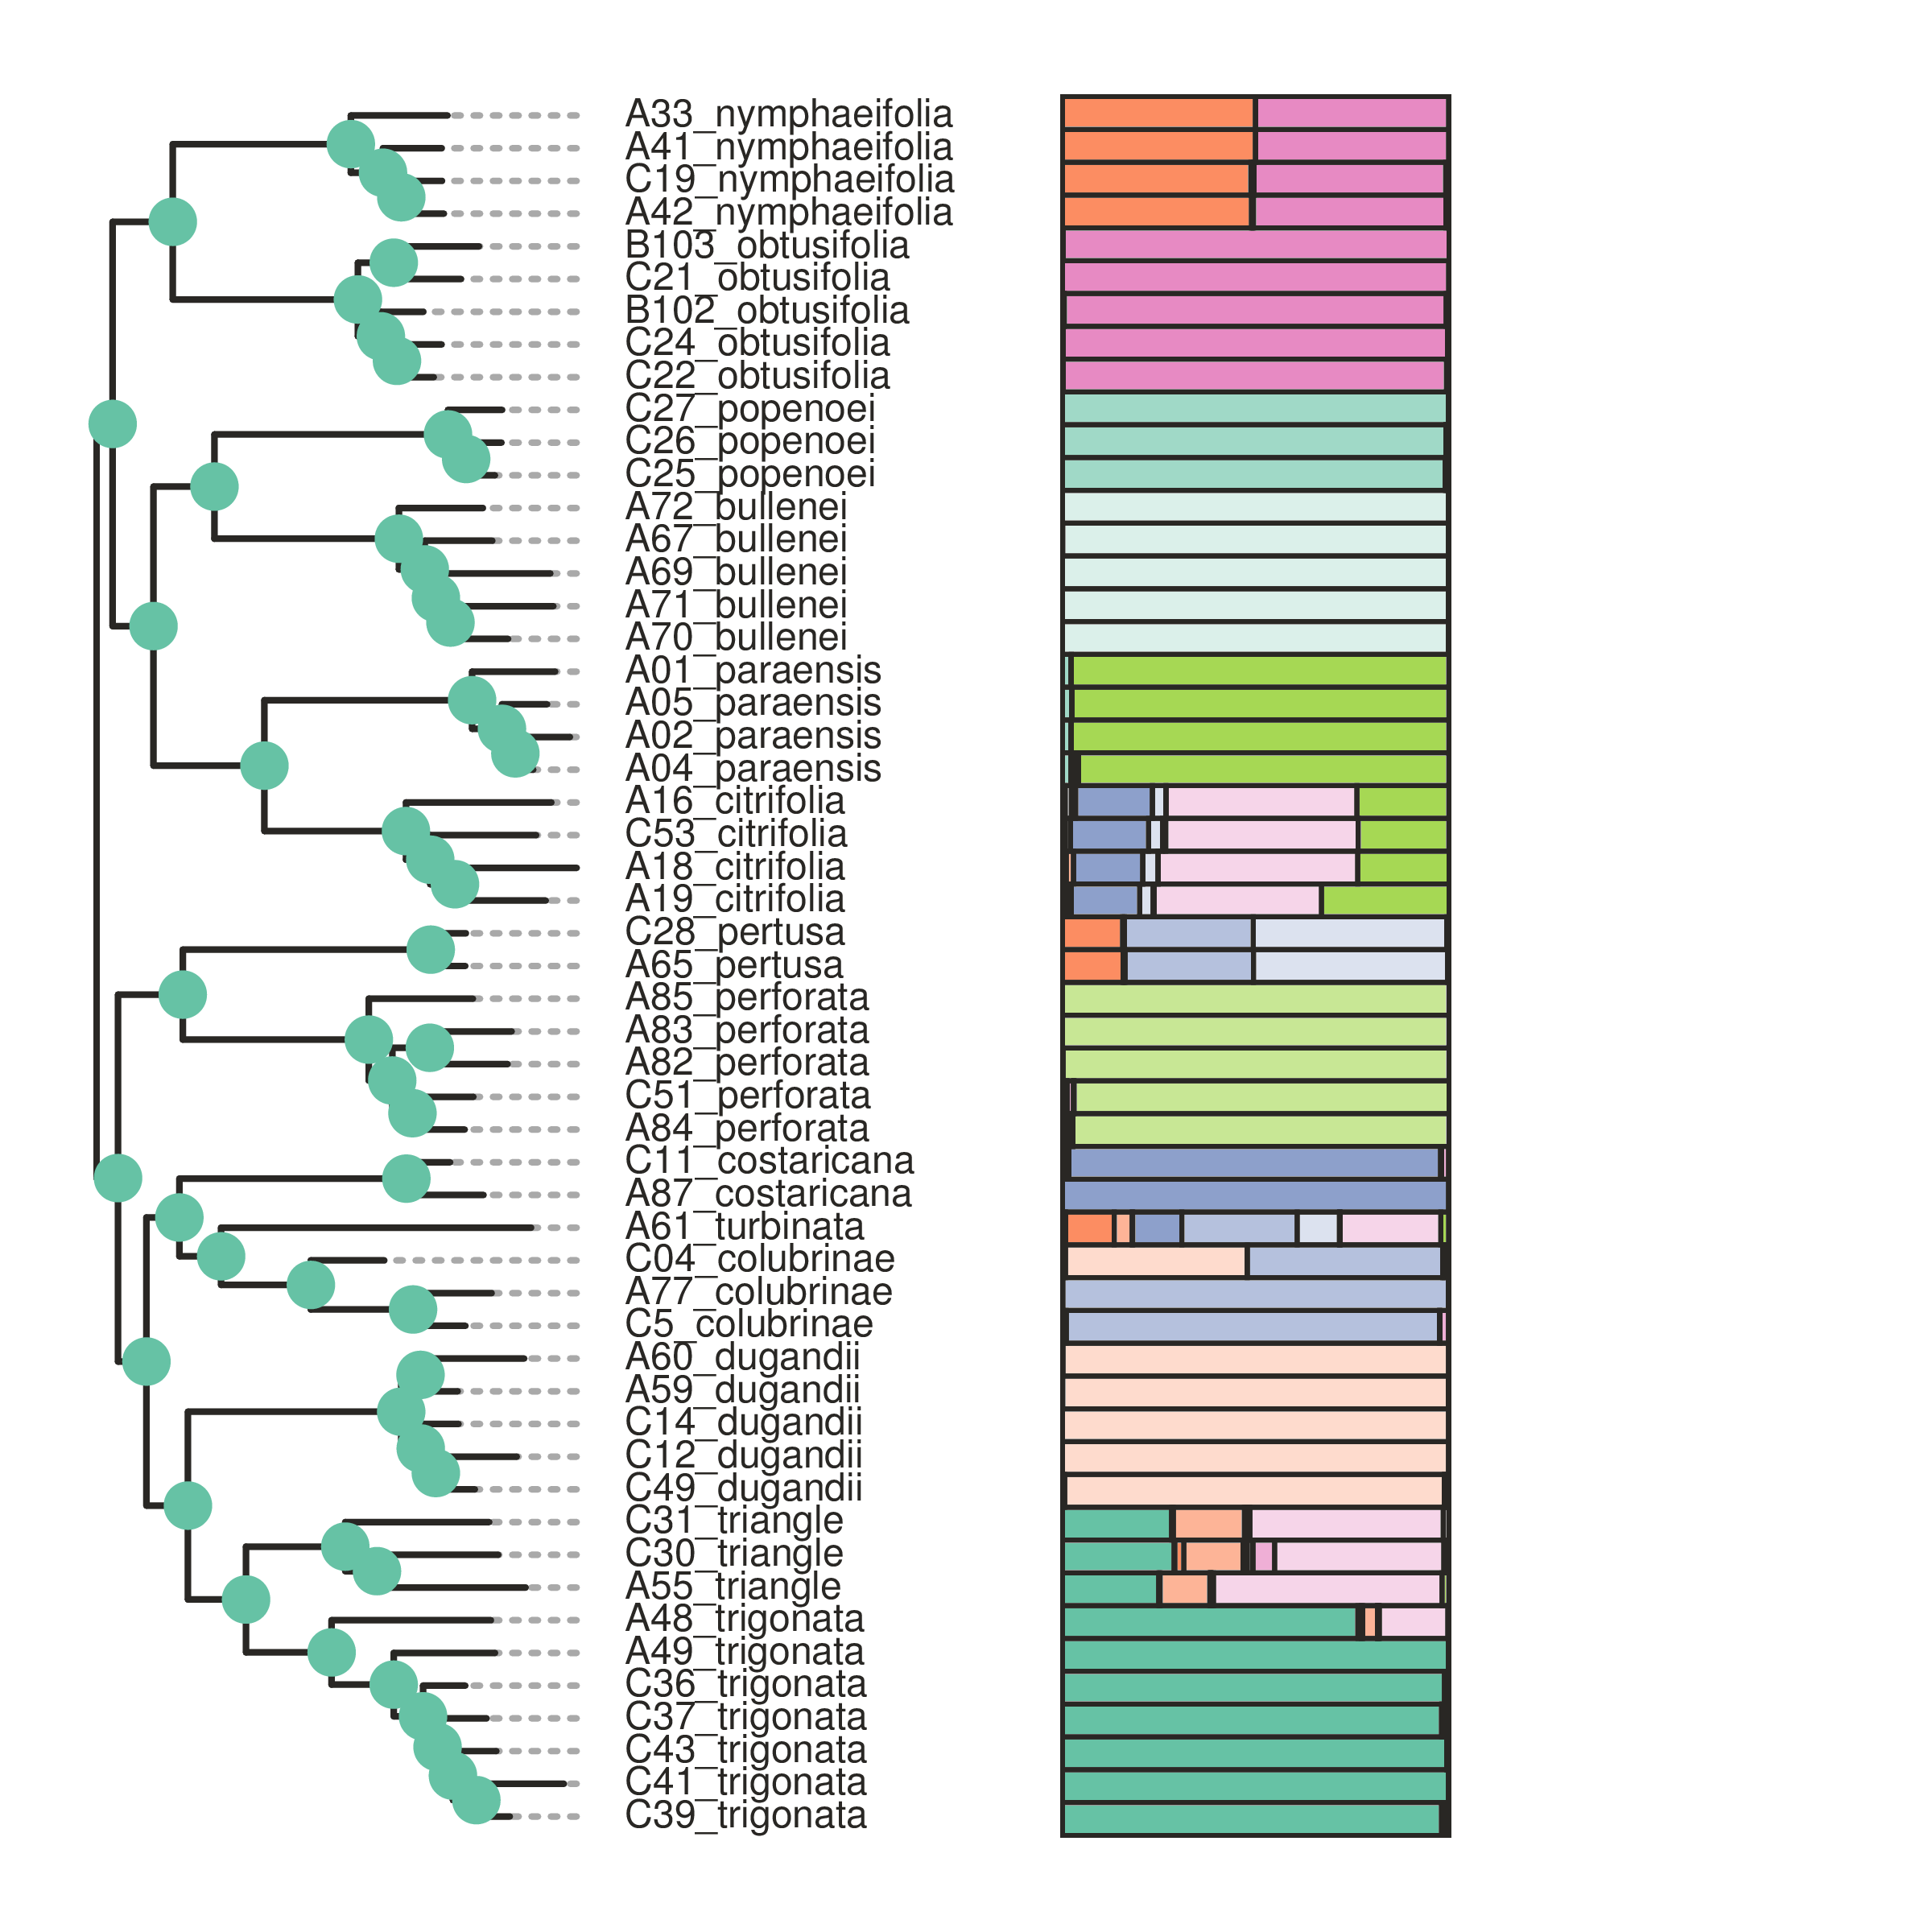

In [154]:
## load trees from raxml results
stre = toytree.tree("analysis-raxml/RAxML_bipartitions.ficus_dhi_s10")
stre.tree.prune(get_subsample_names(data, "americana"))

## choose table
kpop = 14
table = atables[kpop]
table = table.ix[aorder]

## build canvas
c = toyplot.Canvas()
a1 = c.cartesian(bounds=('5%', '50%', '5%', '95%'))
a2 = c.cartesian(bounds=('55%', '75%', '5%', '95%'))
a1.show=False
a2.show=False

## draw plots
stre.draw(axes=a1, 
         use_edge_lengths=True,
         tip_labels_align=True,
         node_labels=stre.get_node_values("support"));
a2.bars(table[::-1], style=style, color=clist[:kpop], along='y');

## save the plot
import toyplot.pdf
toyplot.html.render(c, "figures/americana-tree-struct.html")
toyplot.pdf.render(c, "figures/americana-tree-struct.pdf")
c

### Pharmacosyceae structure plots

In [36]:
for kpop in [2, 3, 4, 5]:
    ## parse outfile to a table and re-order it
    table = ptables[kpop]
    table = table.ix[porder]
    
    ## further styling of plot with css 
    style = {"stroke":toyplot.color.near_black, 
             "stroke-width": 1.5}
    
    ## plot barplot w/ hover
    canvas = toyplot.Canvas(width=600, height=250)
    axes = canvas.cartesian(bounds=("5%", "90%", "10%", "45%"))
    axes.bars(table, style=style)#title=hover(table), style=style)

    ticklabels = [i for i in table.index.tolist()]
    axes.x.ticks.locator = toyplot.locator.Explicit(labels=ticklabels)
    axes.x.ticks.labels.angle = -60
    axes.x.ticks.show = True
    axes.x.ticks.labels.offset = 10
    axes.x.ticks.labels.style = {"font-size": "12px"}
    axes.x.spine.style = style
    axes.y.show = False

A96_glabrata A97_glabrata B133_glabrata B134_glabrata B130_glabrataXmaxima B131_glabrataXmaxima A95_insipida B126_insipida B127_insipida B128_insipida C15_insipida C50_insipida A94_maxima B118_maxima B119_maxima B120_maxima B123_maxima C17_maxima C18_maxima C48_tonduzii C45_yoponensis C46_yoponensis C47_yoponensis 
 
 
 Save as .csv

A96_glabrata A97_glabrata B133_glabrata B134_glabrata B130_glabrataXmaxima B131_glabrataXmaxima A95_insipida B126_insipida B127_insipida B128_insipida C15_insipida C50_insipida A94_maxima B118_maxima B119_maxima B120_maxima B123_maxima C17_maxima C18_maxima C48_tonduzii C45_yoponensis C46_yoponensis C47_yoponensis 
 
 
 Save as .csv

A96_glabrata A97_glabrata B133_glabrata B134_glabrata B130_glabrataXmaxima B131_glabrataXmaxima A95_insipida B126_insipida B127_insipida B128_insipida C15_insipida C50_insipida A94_maxima B118_maxima B119_maxima B120_maxima B123_maxima C17_maxima C18_maxima C48_tonduzii C45_yoponensis C46_yoponensis C47_yoponensis 
 
 
 Save as .csv

A96_glabrata A97_glabrata B133_glabrata B134_glabrata B130_glabrataXmaxima B131_glabrataXmaxima A95_insipida B126_insipida B127_insipida B128_insipida C15_insipida C50_insipida A94_maxima B118_maxima B119_maxima B120_maxima B123_maxima C17_maxima C18_maxima C48_tonduzii C45_yoponensis C46_yoponensis C47_yoponensis 
 
 
 Save as .csv

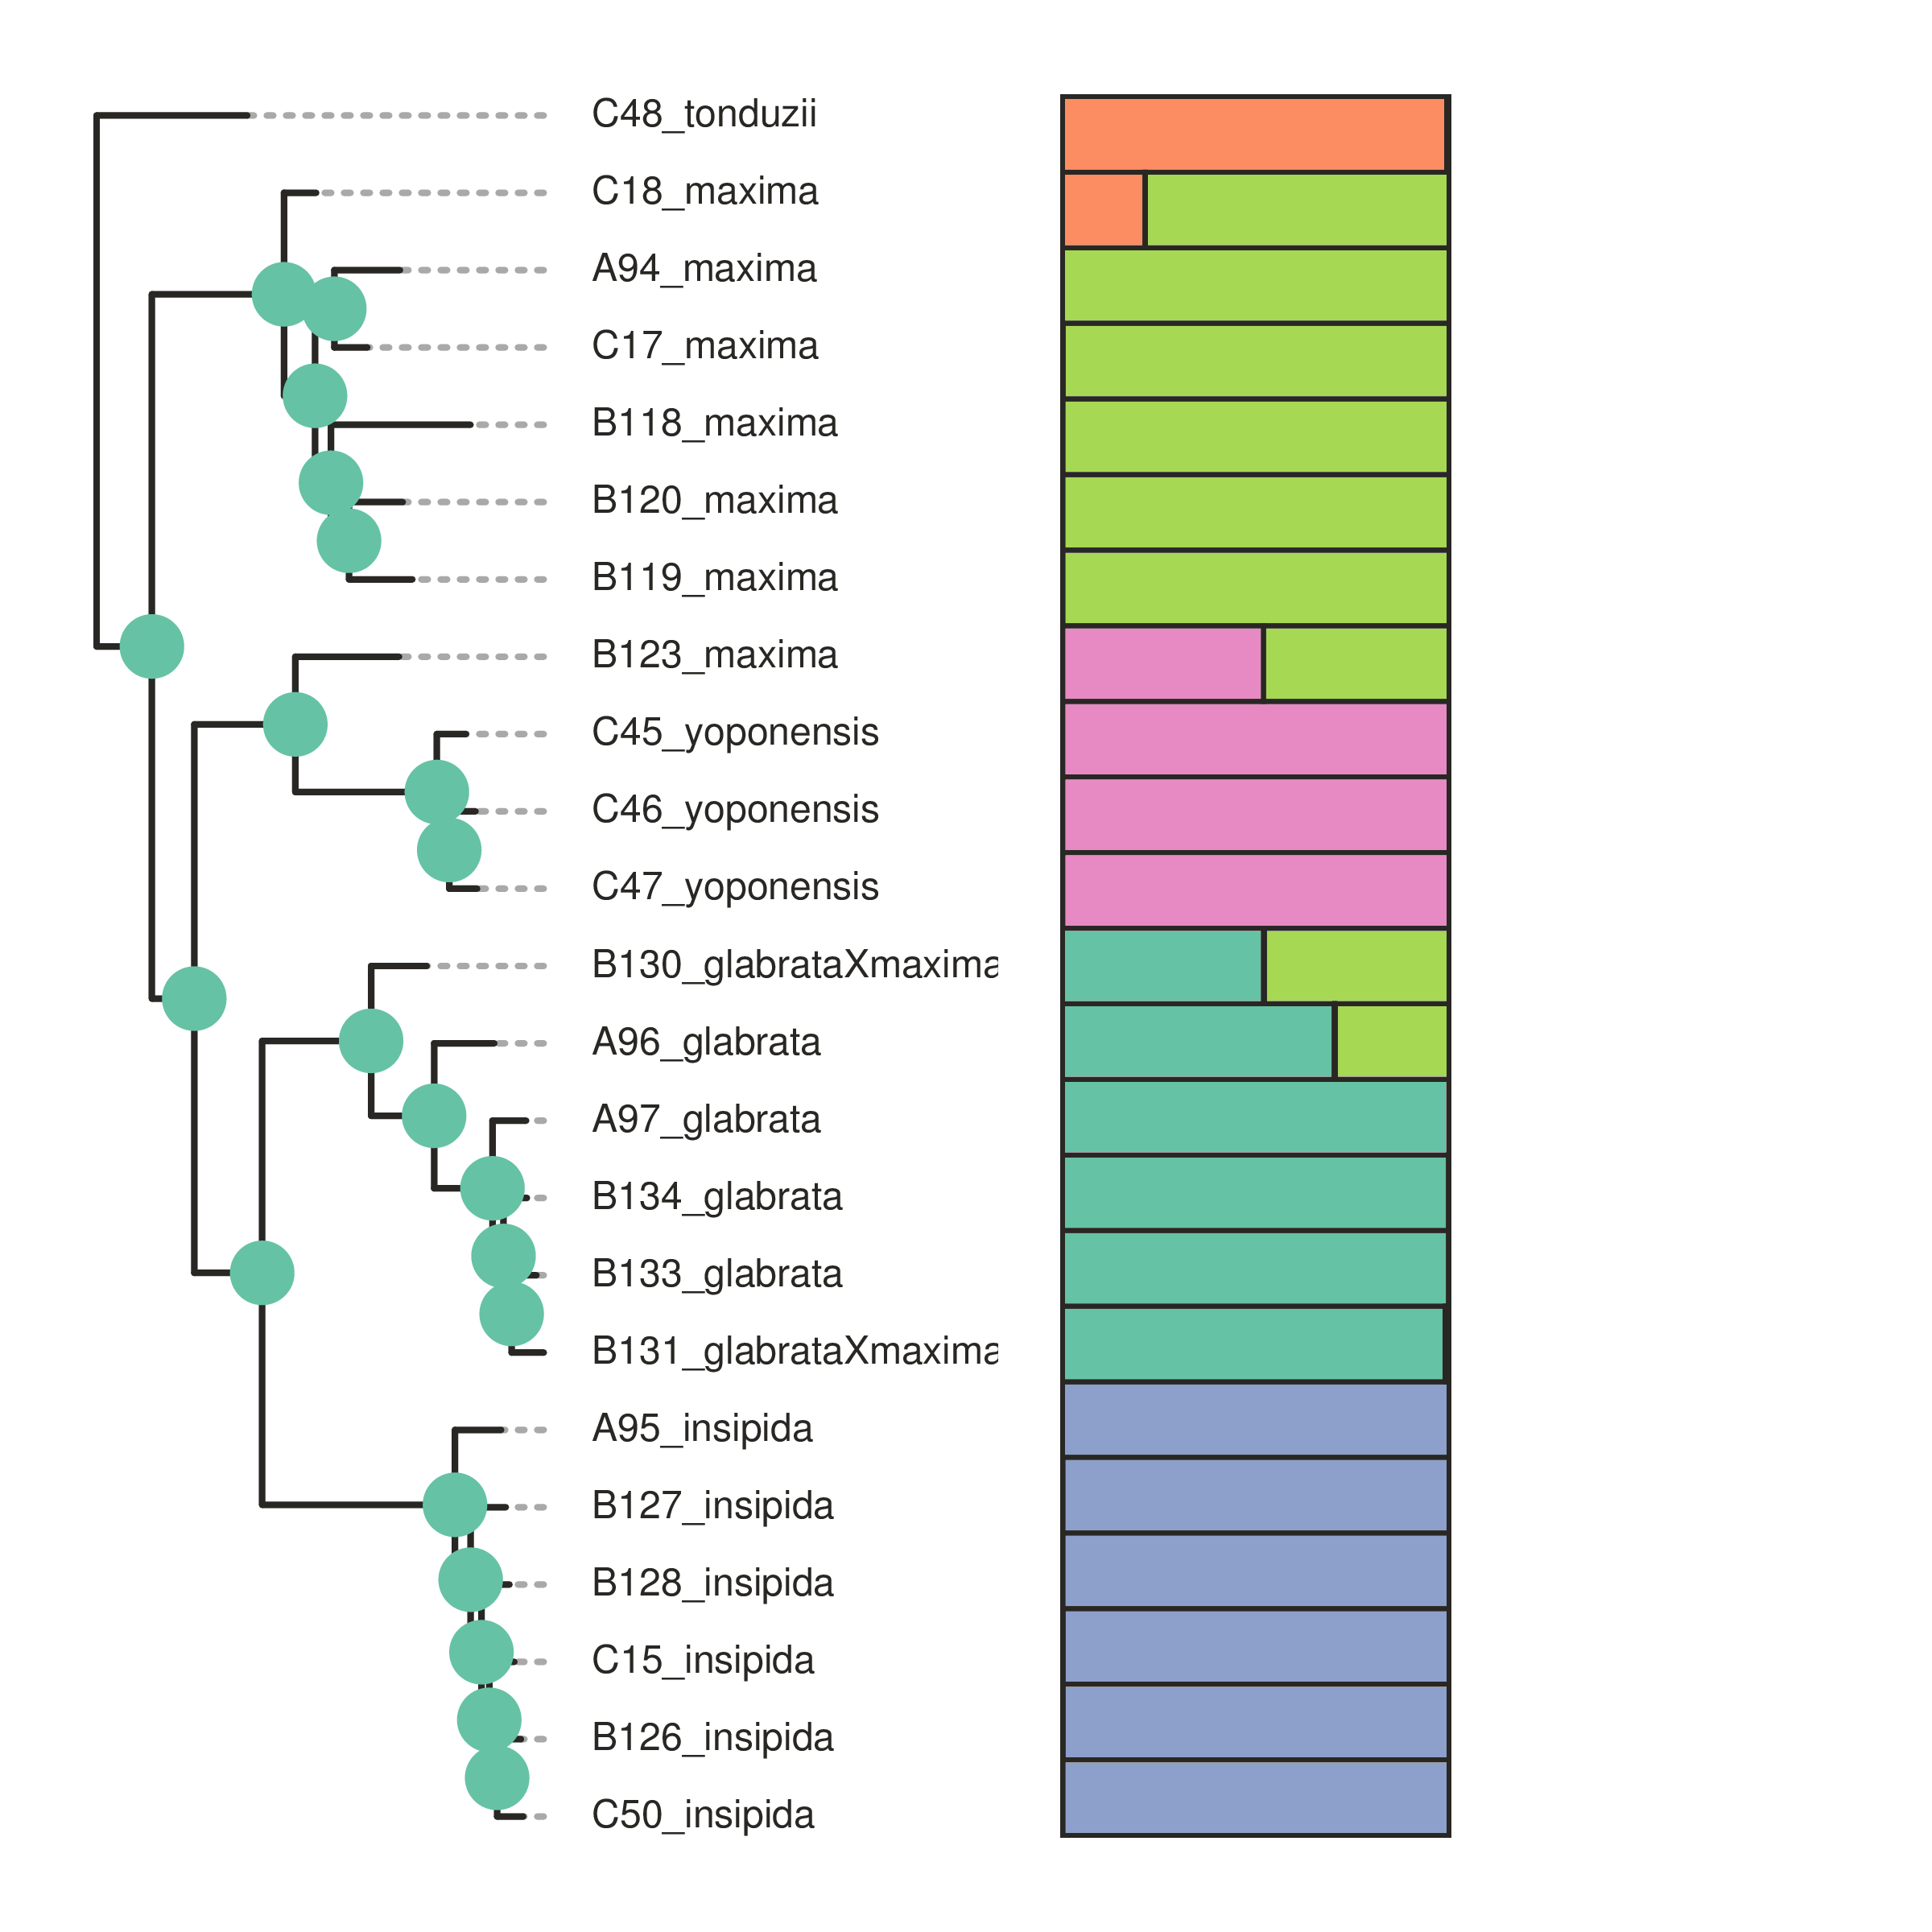

In [179]:
## load trees from raxml results
stre = toytree.tree("analysis-raxml/RAxML_bipartitions.ficus_dhi_s10")
stre.tree.prune(get_subsample_names(parent, "pharmacosycea"))

## choose table
kpop = 5
table = ptables[kpop]
table = table.ix[porder]

## build canvas
c = toyplot.Canvas()
a1 = c.cartesian(bounds=('5%', '50%', '5%', '95%'))
a2 = c.cartesian(bounds=('55%', '75%', '5%', '95%'))
a1.show=False
a2.show=False

## draw plots
stre.draw(axes=a1, 
         use_edge_lengths=True,
         tip_labels_align=True,
         node_size=20,
         node_labels=stre.get_node_values("support"));
a2.bars(table[::-1], 
        style=style, 
        #color=clist[:kpop], 
        along='y');

## save the plot
import toyplot.pdf
toyplot.html.render(c, "figures/pharma-tree-struct.html")
toyplot.pdf.render(c, "figures/pharma-tree-struct.pdf")
c